In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import numpy as np
import math

In [2]:
# Read and parse the CSV file, assigning proper column names
def read_FA_file(filename):
    try:
        df = pd.read_csv(filename, header=None)
        df.columns = ['Column1', 'ID', 'Column3', 'Timestamp', 'X', 'Y', 'Z']
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
        return df
    except FileNotFoundError:
        print(f"The file {filename} was not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [3]:
# Filter data by a specific individual's ID
def get_individual(data, individual_id):
    return data[data['ID'] == individual_id]


In [4]:
# Get data within a specified time interval
def get_interval(data, start_time, end_time):
    try:
        # data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='ms')
        mask = (data['Timestamp'] >= pd.to_datetime(start_time)) & (data['Timestamp'] <= pd.to_datetime(end_time))
        return data.loc[mask]
    except Exception as e:
        print(f"An error occurred while filtering by interval: {e}")
        return pd.DataFrame()

In [5]:
# Remove spikes from the signal and return both the cleaned signal and the locations of the spikes
def remove_spikes_and_identify(y_data, spike_threshold):
    # Using median filter to smooth the signal
    median_signal = medfilt(y_data, kernel_size=41)
    diff_signal = abs(y_data - median_signal)
    spikes = diff_signal > spike_threshold
    fixed_y_data = y_data.copy()
    fixed_y_data[spikes] = median_signal[spikes]
    return fixed_y_data, spikes

In [6]:
def calculate_velocity(data):
    # Convert the 'Timestamp' column to datetime format for time operations
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    # Calculate the time difference between each consecutive timestamp in seconds
    data['TimeDiff'] = data['Timestamp'].diff().dt.total_seconds()
    # Calculate the difference in the 'X' position between each consecutive reading
    data['X_diff'] = data['X'].diff()
    # Calculate the difference in the 'Y' position between each consecutive reading
    data['Y_diff'] = data['Y'].diff()
    # Calculate the velocity using the Pythagorean theorem and dividing by time difference
    data['Velocity'] = np.sqrt(data['X_diff']**2 + data['Y_diff']**2) / data['TimeDiff']
    # Fill any NaN values with 0 which might occur for the first calculation
    data['Velocity'] = data['Velocity'].fillna(0)
    # Return the modified DataFrame with the new 'Velocity' column added
    return data

In [7]:
def calculate_acceleration(data):
    # Calculate acceleration using the velocity difference
    data['Acceleration'] = data['Velocity'].diff() / data['TimeDiff']
    # Fill NaN values with 0 which might occur for the first calculation
    data['Acceleration'] = data['Acceleration'].fillna(0)
    # Return the modified DataFrame with the 'Acceleration' column added
    return data

In [8]:
def calculate_angular_observables(data):

    # Calculate slope
    data['Slope'] = data['Y'].diff() / data['X'].diff()
    data['Slope'] = data['Slope'].fillna(0)

    # Calculate angle theta
    data['Theta'] = data['Slope'].apply(lambda slope: math.atan(slope) if not math.isnan(slope) else None)
    data['Theta'] = np.degrees(data['Theta'])
    data['Theta'] = data['Theta'].fillna(0)
    data['Cosine'] = data['Theta'].apply(lambda theta: math.cos(theta) if not math.isnan(theta) else None)

    data['Theta_diff'] = data['Theta'].diff()
    data['Theta_diff'] = data['Theta_diff'].fillna(0)

    return data

In [9]:
def combined_plots(interval_data, fixed_signal, spikes, velocity_threshold, acc_threshold):
    # Set up a grid of plots with 2 rows and 3 columns
    # The first row for the original and cleaned signals, and velocity distribution
    # The second row for the scatter plots with original and cleaned data, and highlighted speeds
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    # Original signal over time with spikes highlighted
    axs[0, 0].plot(interval_data['Timestamp'], interval_data['Y'], label='Original Signal')
    axs[0, 0].scatter(interval_data['Timestamp'][spikes], interval_data['Y'][spikes], color='red', label='Spikes')
    #axs[0, 0].set_title('Original Signal Over Time with Spikes')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('Y')
    axs[0, 0].legend()

    # Cleaned signal over time
    axs[0, 1].plot(interval_data['Timestamp'], fixed_signal, label='Fixed Signal', color='orange')
    #axs[0, 1].set_title('Cleaned Signal Over Time')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Y cleaned')
    axs[0, 1].legend()

    # Velocity distribution
    axs[0, 2].hist(interval_data['Velocity'], bins=30, color='blue', alpha=0.7)
    #axs[0, 2].set_title('Velocity Distribution')
    axs[0, 2].set_xlabel('Velocity')
    axs[0, 2].set_ylabel('Frequency')

    # acceleration distribution
    axs[0, 3].hist(interval_data['Acceleration'], bins=30, color='blue', alpha=0.7)
    #axs[0, 3].set_title('acc Distribution')
    axs[0, 3].set_xlabel('Acceleration')
    axs[0, 3].set_ylabel('Frequency')

    # Scatter plot with original data
    axs[1, 0].scatter(interval_data['X'], interval_data['Y'], label='Original Data', alpha=0.5)
    axs[1, 0].scatter(interval_data['X'][spikes], interval_data['Y'][spikes], color='red', label='Spikes', alpha=0.5)
    #axs[1, 0].set_title('Scatter Plot with Spikes Highlighted')
    axs[1, 0].set_xlabel('X')
    axs[1, 0].set_ylabel('Y')
    axs[1, 0].legend()

    # Scatter plot with cleaned data
    axs[1, 1].scatter(interval_data['X'], fixed_signal, label='Data after Spike Removal', color='orange', alpha=0.5)
    #axs[1, 1].set_title('Cleaned Data Scatter Plot')
    axs[1, 1].set_xlabel('X')
    axs[1, 1].set_ylabel('Y cleaned')
    axs[1, 1].legend()

    # Scatter plot with speeds highlighted
    normal_speeds = interval_data['Velocity'] <= velocity_threshold
    abnormal_speeds = interval_data['Velocity'] > velocity_threshold
    axs[1, 2].scatter(interval_data['X'][normal_speeds], interval_data['Y'][normal_speeds], label='Normal Speed', alpha=0.5)
    axs[1, 2].scatter(interval_data['X'][abnormal_speeds], interval_data['Y'][abnormal_speeds], color='red', label='Abnormal Speed', alpha=0.5)
    #axs[1, 2].set_title('Scatter Plot with Speeds Highlighted')
    axs[1, 2].set_xlabel('X Position')
    axs[1, 2].set_ylabel('Y Position')
    axs[1, 2].legend()

    # Scatter plot with acceleration highlighted
    normal_acc = interval_data['Acceleration'] <= acc_threshold
    abnormal_acc = interval_data['Acceleration'] > acc_threshold
    axs[1, 3].scatter(interval_data['X'][normal_acc], interval_data['Y'][normal_acc], label='Normal Acceleration', alpha=0.5)
    axs[1, 3].scatter(interval_data['X'][abnormal_acc], interval_data['Y'][abnormal_acc], color='red', label='Abnormal Acceleration', alpha=0.5)
    #axs[1, 3].set_title('Scatter Plot with Acceleration Highlighted')
    axs[1, 3].set_xlabel('X Position')
    axs[1, 3].set_ylabel('Y Position')
    axs[1, 3].legend()

    plt.tight_layout()
    plt.savefig("com_plot.png")
    plt.show()

In [10]:
def angular_plots(data, spikes):
    """Plot angular quantities with or without spikes."""
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # Theta Distribution
    # axs[0].hist(data['Theta'][~spikes], bins=30, color='blue', alpha=0.7)       # without spikes
    # axs[0].hist(data['Theta'][spikes], bins=30, color='red', alpha=0.7)         # only spikes
    axs[0].hist(data['Theta'], bins=30, color='blue', alpha=0.7)                  # all data
    axs[0].set_xlabel('Theta')
    axs[0].set_ylabel('Frequency')

    # Cosine Theta Distribution
    # axs[1].hist(data['Cosine'][~spikes], bins=30, color='blue', alpha=0.7)
    # axs[1].hist(data['Cosine'][spikes], bins=30, color='red', alpha=0.7)
    axs[1].hist(data['Cosine'], bins=30, color='blue', alpha=0.7)
    axs[1].set_xlabel('Cosine')
    axs[1].set_ylabel('Frequency')
    
    # Theta Difference Distribution
    # axs[2].hist(data['Theta_diff'][~spikes], bins=30, color='blue', alpha=0.7)
    # axs[2].hist(data['Theta_diff'][spikes], bins=30, color='red', alpha=0.7)
    axs[2].hist(data['Theta_diff'], bins=30, color='blue', alpha=0.7)
    axs[2].set_xlabel('Theta Diff')
    axs[2].set_ylabel('Frequency')
    
    # Velocity vs Theta Diff Distribution
    # axs[3].scatter(data['Velocity'][~spikes], data['Theta_diff'][~spikes], alpha=0.7)
    # axs[3].scatter(data['Velocity'][spikes], data['Theta_diff'][spikes],  color='red', alpha=0.7)
    axs[3].scatter(data['Velocity'], data['Theta_diff'], alpha=0.7)
    axs[3].set_xlabel('Velocity')
    axs[3].set_ylabel('Theta Diff')

    # Adjust layout and save figure.
    plt.tight_layout()
    plt.savefig("ang_plot.png")
    plt.show()

- **main():**

In [11]:
# 7 days data of cows
filenames = [
    'FA_20200919T000000UTC.csv',
    'FA_20200920T000000UTC.csv',
    'FA_20200921T000000UTC.csv',
    'FA_20200922T000000UTC.csv',
    'FA_20200923T000000UTC.csv',
    'FA_20200924T000000UTC.csv',
    'FA_20200925T000000UTC.csv',
]

# 1 day data of cows
filenames = ['FA_20191115T000000UTC.csv']

In [12]:
datafiles = []
for filename in filenames:
    print("Processing File: {}".format(filename))
    data = read_FA_file(filename)
    datafiles.append(data)

alldata = pd.concat(datafiles)

Processing File: FA_20191115T000000UTC.csv


In [13]:
# filter cow data
individual_id = 2417246
start_time = '2019-11-15 02:05:00'
end_time = '2019-11-15 02:20:00'
spike_threshold = 200

In [14]:
alldata.head()

,Column1,ID,Column3,Timestamp,X,Y,Z
0,FA,2428125,00250CDD,2019-11-15 00:00:00.223,867,6945,198
1,FA,2421705,0024F3C9,2019-11-15 00:00:00.016,895,1636,198
2,FA,2431953,00251BD1,2019-11-15 00:00:00.138,2427,7675,198
3,FA,2420328,0024EE68,2019-11-15 00:00:00.198,929,4928,198
4,FA,2421875,0024F473,2019-11-15 00:00:00.118,2364,7387,198


In [15]:
# fetch data of single cow
data = get_individual(alldata, individual_id)

In [16]:
# fetch data of single cow in a time interval
data = get_interval(data, start_time, end_time)

In [17]:
# add cow velocity
data = calculate_velocity(data)

In [18]:
# add cow acceleration
data = calculate_acceleration(data)

In [19]:
# add angular variables
data = calculate_angular_observables(data)

In [20]:
# spikes removal
fixed_signal, spikes = remove_spikes_and_identify(data['Y'], spike_threshold)

In [21]:
# Ensure 'Velocity' column exists before trying to access it
if 'Velocity' in data.columns:
    velocity_threshold = np.percentile(data['Velocity'], 95)
    print(f"The calculated velocity threshold is: {velocity_threshold}")

# Ensure 'Acceleration' column exists before trying to access it
if 'Acceleration' in data.columns:
    acceleration_threshold = np.percentile(data['Acceleration'], 95)
    print(f"The calculated acceleration threshold is: {acceleration_threshold}")

The calculated velocity threshold is: 47.14510711937097
The calculated acceleration threshold is: 16.178731804863368


### _Plotting_

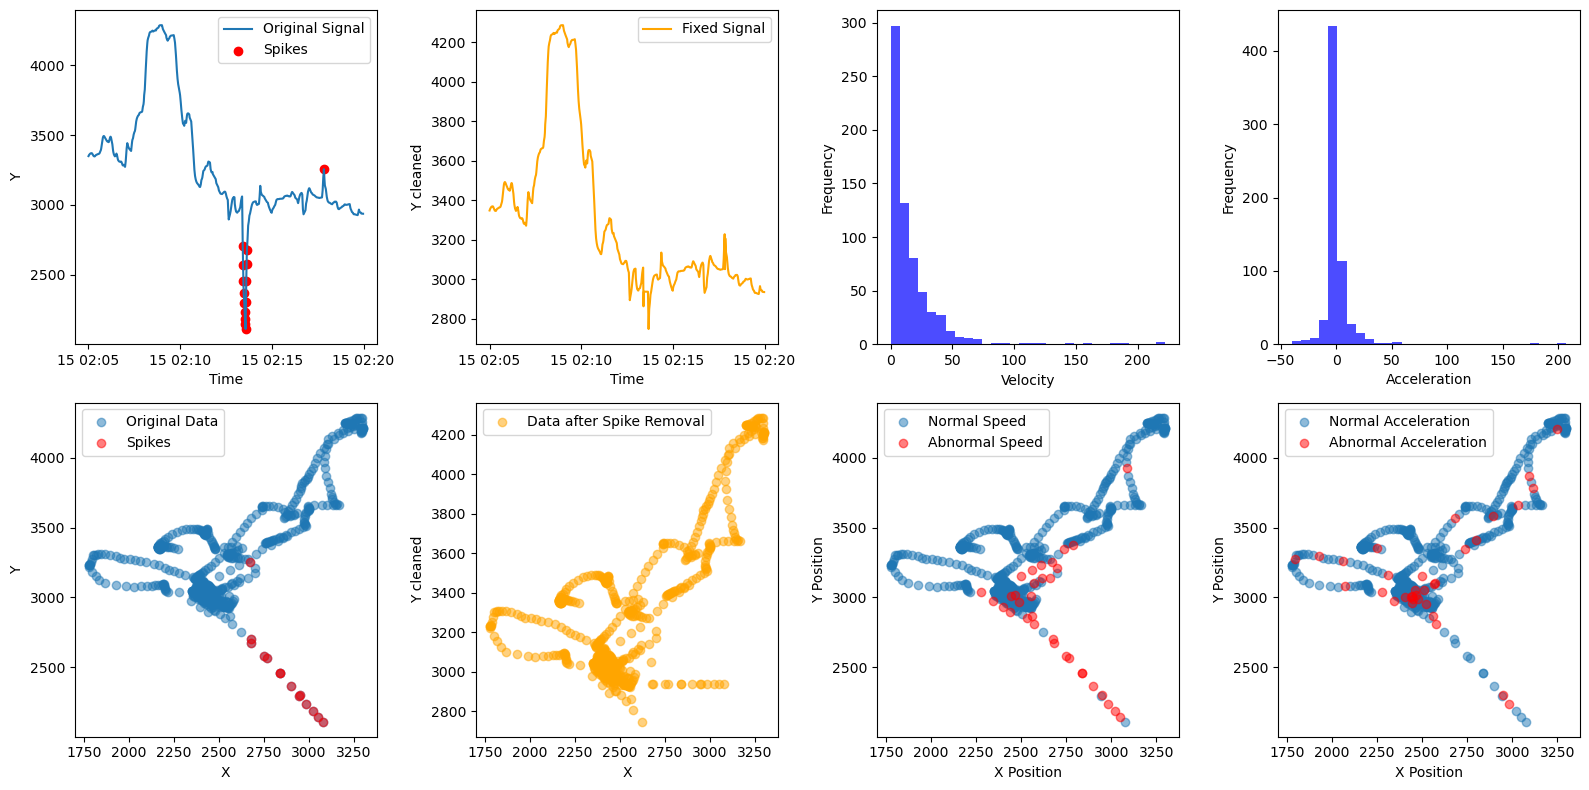

In [22]:
# Use combined plot function here
combined_plots(data, fixed_signal, spikes, velocity_threshold, acceleration_threshold)

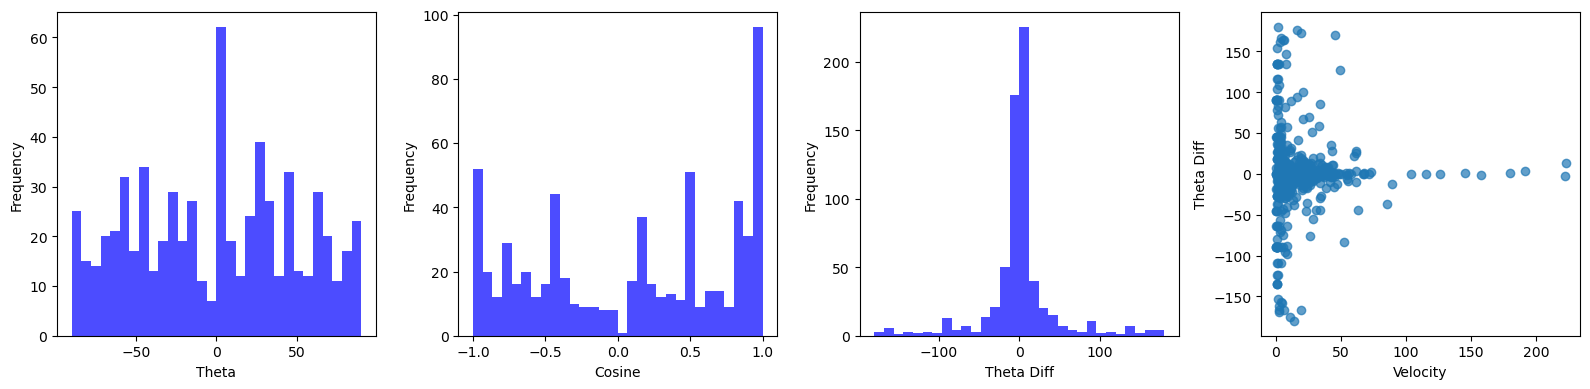

In [23]:
# angular quantities with or without spikes
angular_plots(data, spikes)

### _Remove Stationary Tags_

In [24]:
# detect and drop inactive tags
def detect_drop_inactive_tags(df):
    """Detect and drop stationary tags."""
    
    # get unique cow tags
    unique_tags = df.ID.unique()
    to_drop = []

    # loop over ucows, find stationary tags
    for tag in unique_tags:
        temp = get_individual(df, tag)
        
        x = list(temp['X'])
        y = list(temp['Y'])
        z = list(temp['Z'])
        
        # save stationary tags to a list
        if abs(max(y)-min(y)) <= 2600:          # only check y-direction
            to_drop.append(tag)
    
    # drop stationary tags from the data
    for i in range(len(to_drop)):
        # print("Dropping Stationary Tag: ", cow)
        indexID = df[df.ID == to_drop[i]].index
        df = df.drop(indexID) # drop tags
    
    print("Total Stationary Tag Removed: ", len(to_drop))

    return df

In [25]:
# get list of unique IDs
# alldata.ID.unique()

In [26]:
# get number of unique IDs
# alldata.ID.nunique(dropna=True)

- Remove Stationary Tags

In [27]:
# drop inactive tags
filterdata = detect_drop_inactive_tags(alldata)

Total Stationary Tag Removed:  31


In [28]:
alldata.describe()

,ID,Timestamp,X,Y,Z
count,1.295409e+07,12954087,1.295409e+07,1.295409e+07,12954087.0
mean,2.416069e+06,2019-11-15 11:58:24.031362304,1.622951e+03,5.106541e+03,198.0
min,2.203669e+06,2019-11-15 00:00:00.011000,0.000000e+00,0.000000e+00,198.0
25%,2.423380e+06,2019-11-15 05:57:51.698500096,8.000000e+02,3.813000e+03,198.0
50%,2.428289e+06,2019-11-15 11:51:25.664999936,1.607000e+03,5.139000e+03,198.0
75%,2.428878e+06,2019-11-15 18:09:53.858499840,2.542000e+03,6.852000e+03,198.0
max,2.433166e+06,2019-11-15 23:59:59.992000,3.338000e+03,8.707000e+03,198.0
std,4.675584e+04,NaN,1.020253e+03,2.004287e+03,0.0


In [29]:
filterdata.describe()

,ID,Timestamp,X,Y,Z
count,1.150687e+07,11506874,1.150687e+07,1.150687e+07,11506874.0
mean,2.427558e+06,2019-11-15 11:58:52.459209472,1.562729e+03,5.258934e+03,198.0
min,2.405385e+06,2019-11-15 00:00:00.011000,0.000000e+00,0.000000e+00,198.0
25%,2.426290e+06,2019-11-15 05:58:56.654749952,7.950000e+02,4.037000e+03,198.0
50%,2.428385e+06,2019-11-15 11:51:30.586499840,1.594000e+03,5.233000e+03,198.0
75%,2.428891e+06,2019-11-15 18:11:48.499000064,2.456000e+03,6.931000e+03,198.0
max,2.433166e+06,2019-11-15 23:59:59.992000,3.333000e+03,8.707000e+03,198.0
std,4.148381e+03,NaN,9.777968e+02,1.944059e+03,0.0


- Check Memory Consumption

In [30]:
# memory usage
mem_bytes_all = alldata.memory_usage(index=False).sum()
print('memory usage {:.2f} MB'.format(mem_bytes_all / 2**20))

memory usage 691.82 MB


In [31]:
# memory usage
mem_bytes_filter = filterdata.memory_usage(index=False).sum()
print('memory usage {:.2f} MB'.format(mem_bytes_filter / 2**20))

memory usage 614.53 MB


In [32]:
print('memory reduction {:.2f} MB'.format((mem_bytes_all - mem_bytes_filter) / 2**20))

memory reduction 77.29 MB


#### Memory Consumption Log

- 100, 21.92 MB, Dropped Tags 6
- 200, 33.55 MB, Dropped Tags 13
- 500, 56.92 MB, Dropped Tags 22
- 1000, 74.69 MB, Drooped Tags 30
- 2600, 77.29 MB, Dropped Tags 31

### _Further Analysis_

- In the second step, we used the turning angle together with distance and time difference from surrounding points.

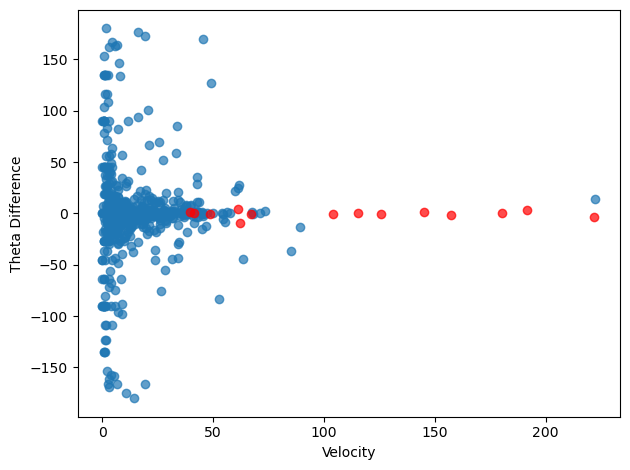

In [33]:
# Velocity vs. Theta Diff Plot
plt.scatter(data['Velocity'][~spikes], data['Theta_diff'][~spikes], alpha=0.7)
plt.scatter(data['Velocity'][spikes], data['Theta_diff'][spikes],  color='red', alpha=0.7)
plt.xlabel('Velocity')
plt.ylabel('Theta Difference')

plt.tight_layout()
plt.savefig("VT1.png")
plt.show()

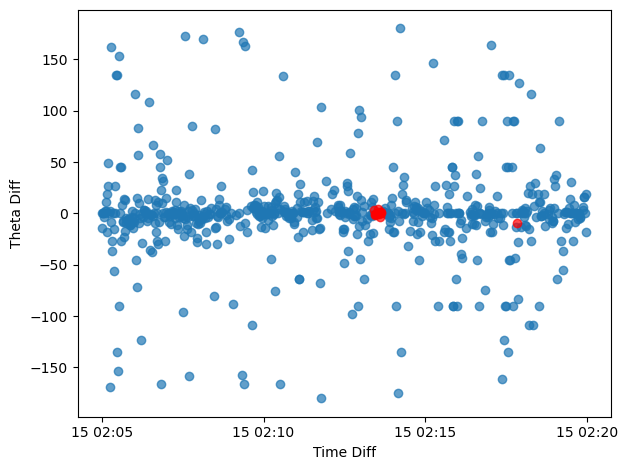

In [34]:
# Time Diff vs. Theta Diff Plot
plt.scatter(data['Timestamp'][~spikes], data['Theta_diff'][~spikes], alpha=0.7);
plt.scatter(data['Timestamp'][spikes], data['Theta_diff'][spikes], color='red', alpha=0.7);
plt.xlabel('Time Diff')
plt.ylabel('Theta Diff')

plt.tight_layout()
plt.savefig("VT2.png")
plt.show()

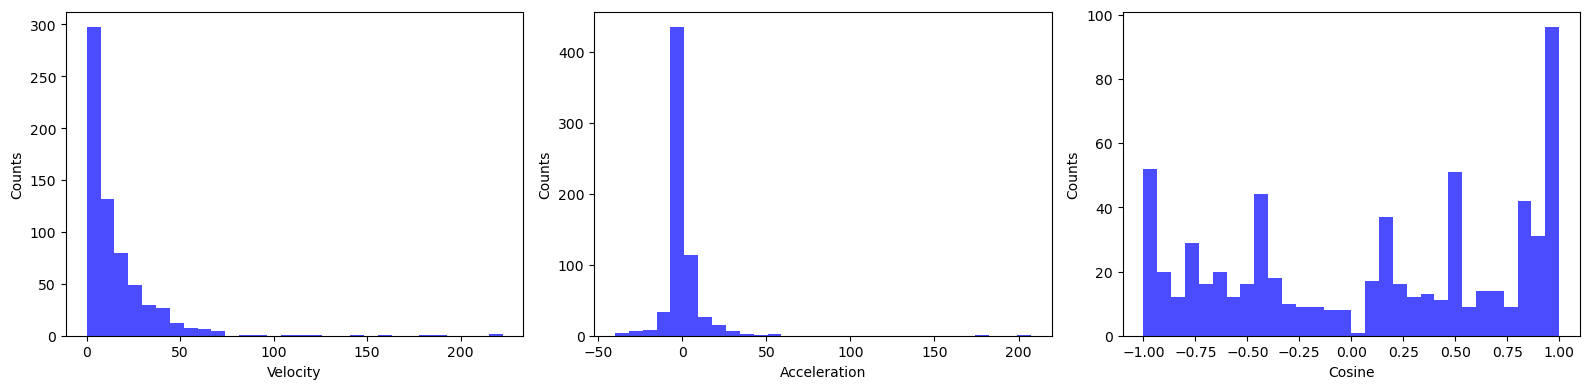

In [35]:
# Velocity, Accelration and Cosine Theta Distributions
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# Velocity Distribution
axs[0].hist(data['Velocity'], bins=30, color='blue', alpha=0.7)
axs[0].set_xlabel('Velocity')
axs[0].set_ylabel('Counts')

# Acceleration Distribution
axs[1].hist(data['Acceleration'], bins=30, color='blue', alpha=0.7)
axs[1].set_xlabel('Acceleration')
axs[1].set_ylabel('Counts')

# Cosine Theta Distribution
axs[2].hist(data['Cosine'], bins=30, color='blue', alpha=0.7)
axs[2].set_xlabel('Cosine')
axs[2].set_ylabel('Counts')

plt.tight_layout()
plt.show()